## ReadCSV and preprocess

In [1]:
library(dplyr)
library(readr)
library(rjags)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'rjags' was built under R version 4.4.3"
Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



In [2]:
# Read your data
df <- read_csv("data.csv")

# Create team indices (important for modeling)
teams <- sort(unique(c(df$home_team, df$away_team)))
team_index <- setNames(seq_along(teams), teams)

df <- df %>%
  mutate(
    H = team_index[home_team],
    A = team_index[away_team]
  )


Rows: 1230 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): game_date, home_team, away_team
dbl (12): game_id, fg3m_home, ftm_home, pts_home, fg3m_away, ftm_away, pts_a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Model in JAGS for free throws

In [3]:
model_string_nb <- "
model {
  # Priors
  for (j in 1:K) {
    att[j] ~ dnorm(mu_att, tau_att)
    def[j] ~ dnorm(mu_def, tau_def)
  }

  mu_att ~ dnorm(0, 0.0001)
  mu_def ~ dnorm(0, 0.0001)
  tau_att ~ dgamma(0.1, 0.1)
  tau_def ~ dgamma(0.1, 0.1)

  c ~ dnorm(3, 0.0001)
  home ~ dnorm(0, 0.0001) T(0,) # strictly positive

  for (i in 1:N) {
    # Home
    HFT[i] ~ dnegbin(pH[i], rH[i])
    log(rH[i]) <- att[H[i]] + def[A[i]] + c + home
    pH[i] ~ dunif(0,1)
    
    # Away
    AFT[i] ~ dnegbin(pA[i], rA[i])
    log(rA[i]) <- att[A[i]] + def[H[i]] + c
    pA[i] ~ dunif(0,1)
  }

  # Identifiability constraints
  att[K+1] <- -sum(att[1:(K-1)])
  def[K+1] <- -sum(def[1:(K-1)]) 
}
"

## Prepare data for rjags

In [4]:
# Assume you've already processed your DataFrame as above
data_list <- list(
  N = nrow(df),
  K = length(teams)-1,
  HFT = df$ftm_home,
  AFT = df$ftm_away,
  H = df$H,
  A = df$A
)

# Run model
model <- jags.model(textConnection(model_string_nb), data = data_list, n.chains = 3)
update(model, 5000)  # Burn-in

samples_nb <- coda.samples(model, variable.names = c("att", "def", "home", "c"), n.iter = 2000)
summary(samples_nb)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2460
   Unobserved stochastic nodes: 2524
   Total graph size: 10937

Initializing model




Iterations = 6001:8000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean      SD  Naive SE Time-series SE
att[1]  -0.0099398 0.10071 0.0013001       0.008299
att[2]  -0.0020966 0.11192 0.0014449       0.010705
att[3]  -0.0385960 0.10631 0.0013724       0.008914
att[4]   0.0242154 0.10134 0.0013083       0.008405
att[5]  -0.0033916 0.10372 0.0013391       0.008501
att[6]  -0.0084927 0.10718 0.0013837       0.008986
att[7]   0.0982502 0.10526 0.0013589       0.009226
att[8]  -0.0536788 0.10647 0.0013745       0.009011
att[9]   0.0798656 0.10366 0.0013382       0.008778
att[10] -0.0002324 0.10282 0.0013274       0.008557
att[11] -0.0047170 0.10809 0.0013954       0.009657
att[12] -0.0591585 0.10588 0.0013669       0.008837
att[13]  0.0119664 0.10670 0.0013775       0.009329
att[14]  0.0027493 0.10016 0.0012931       0.007961
att[15] -0.0547367 0.11

In [5]:
#coda::gelman.diag(samples_nb)  # > 1.1, problem with posterior

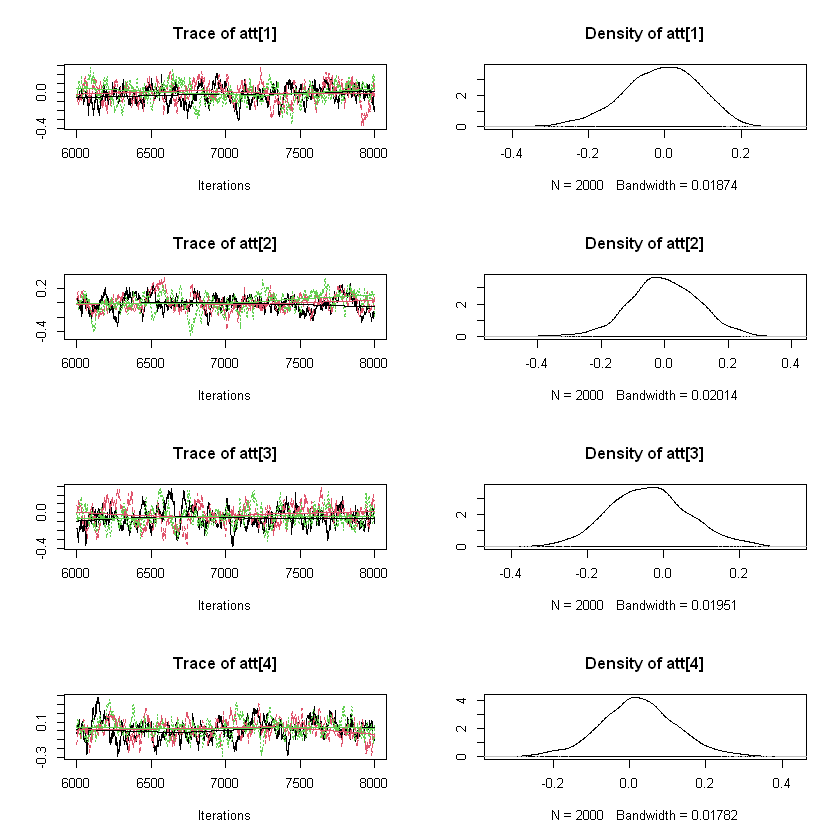

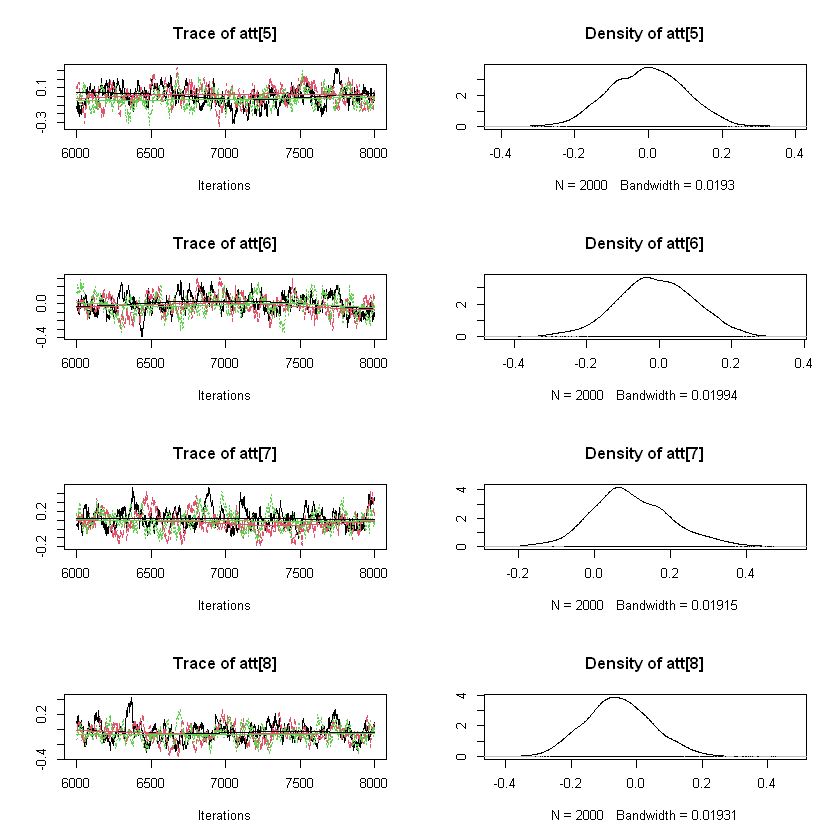

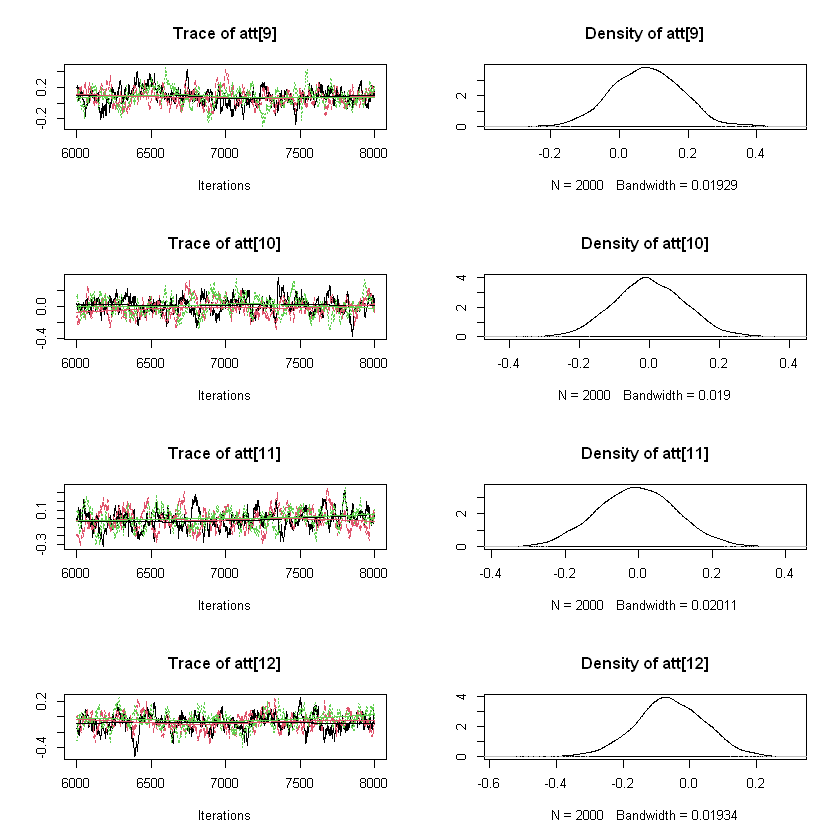

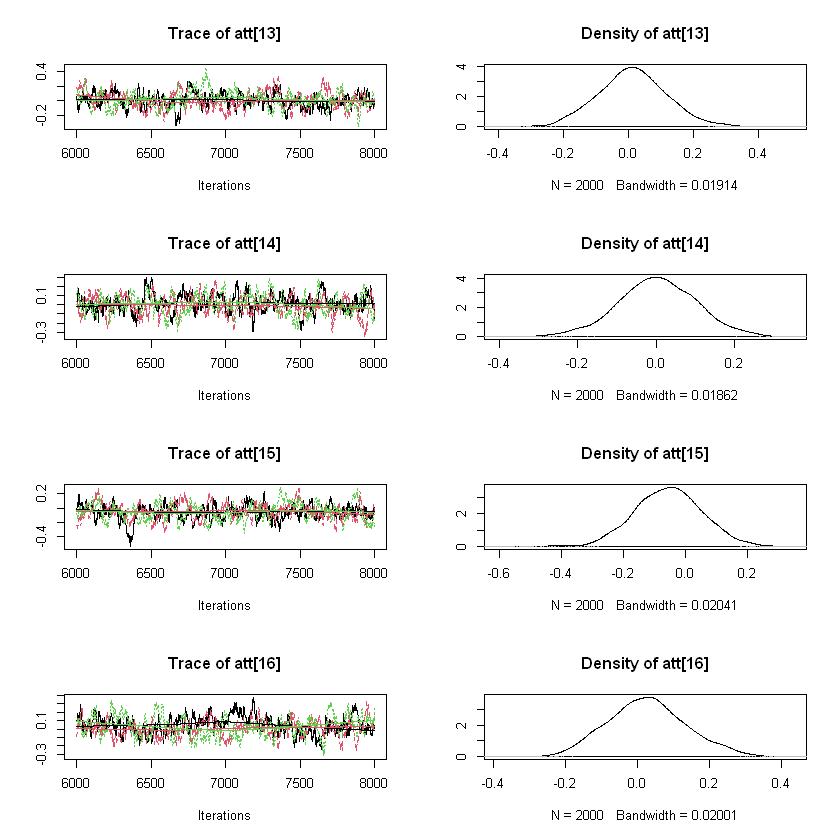

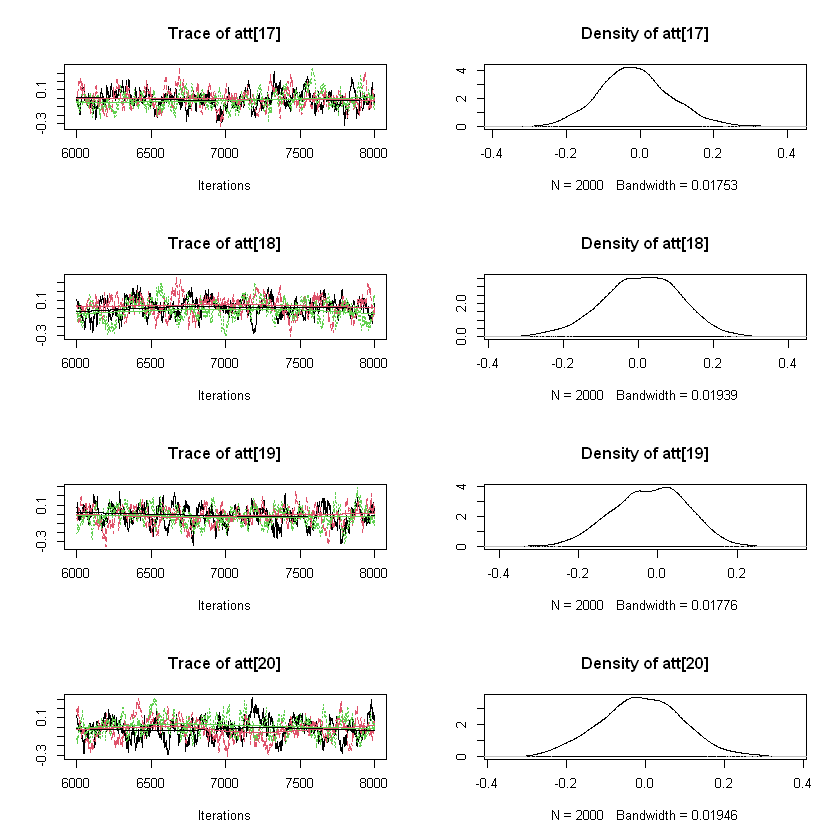

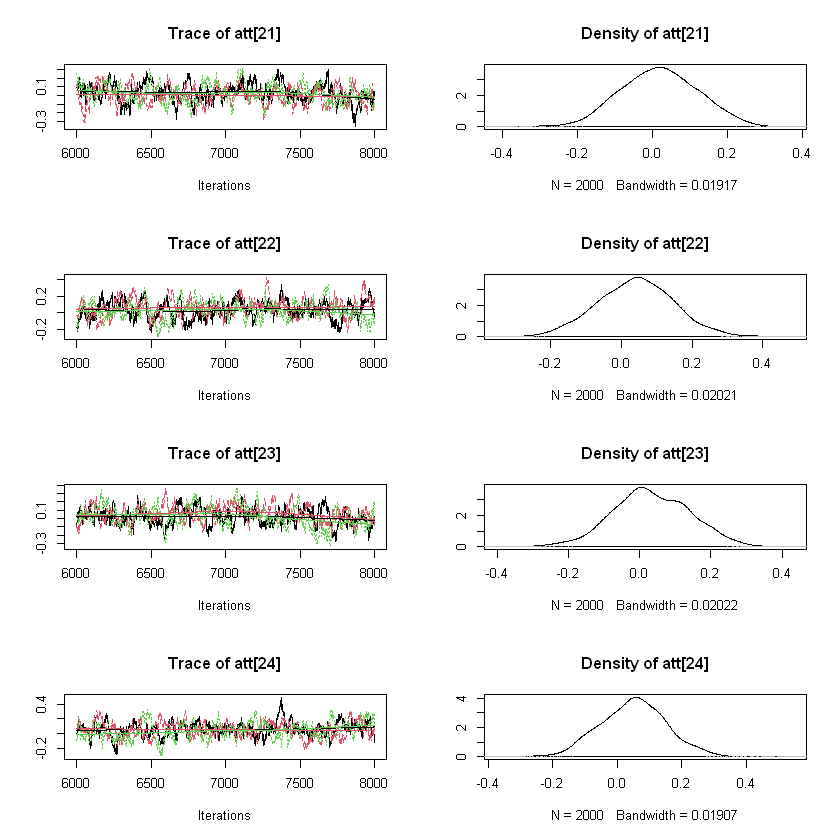

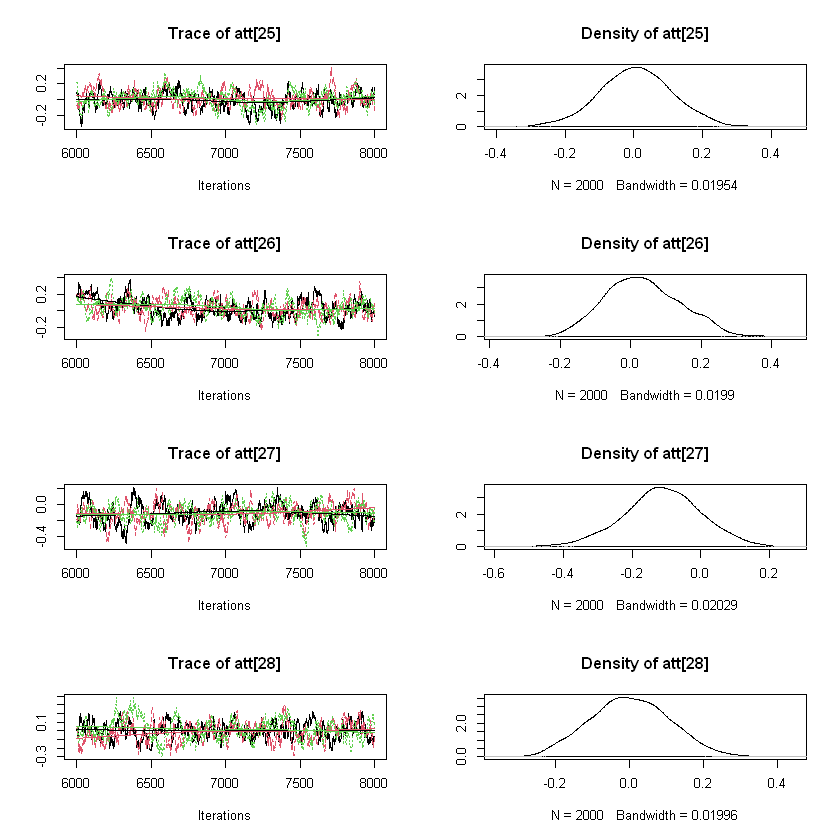

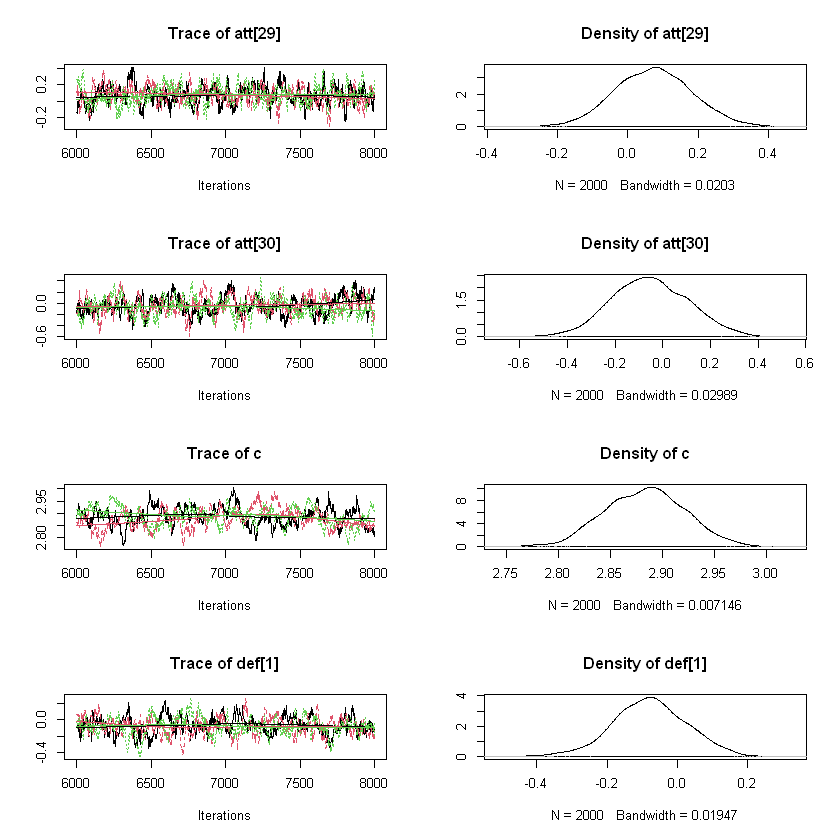

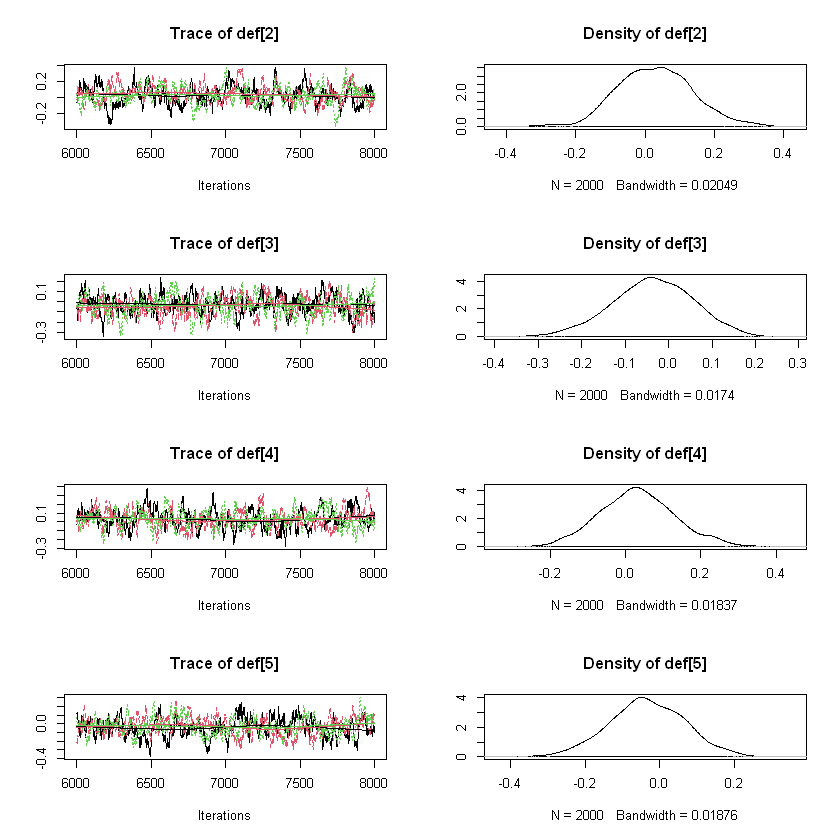

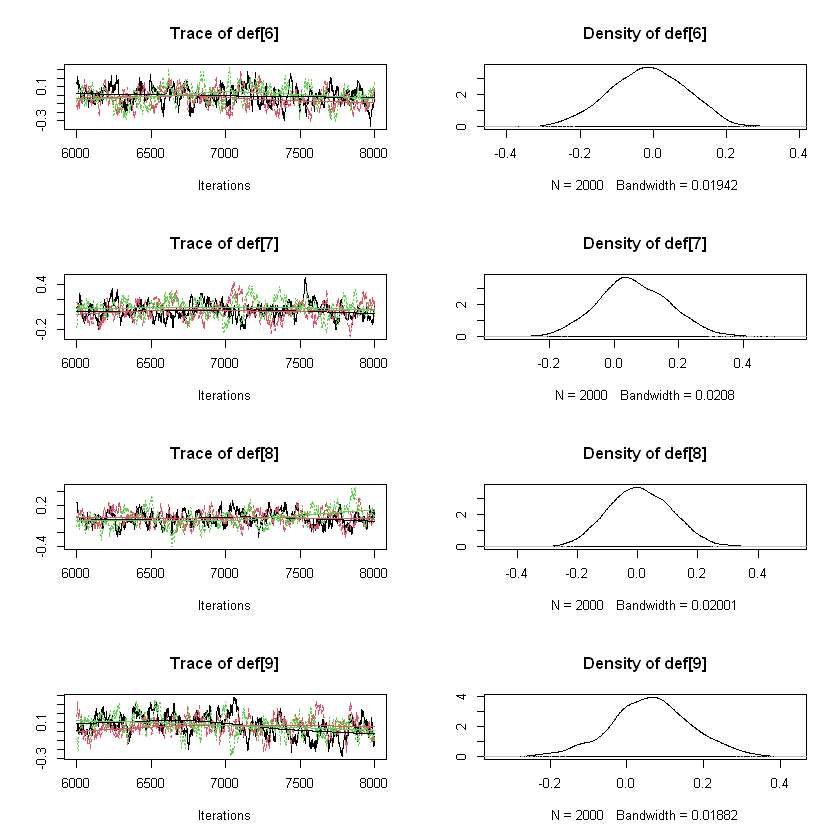

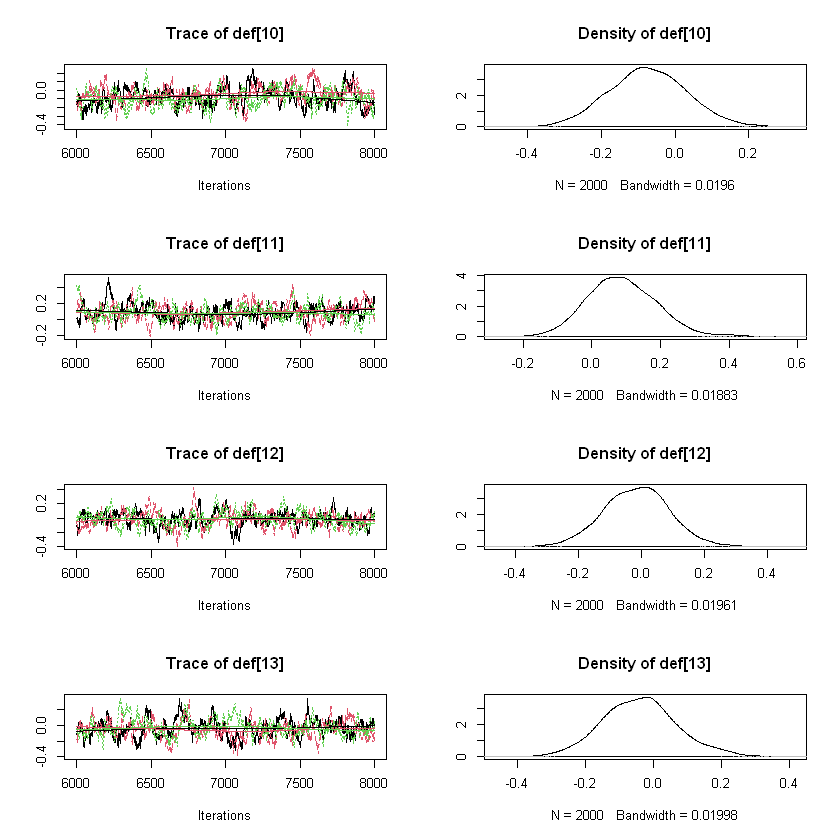

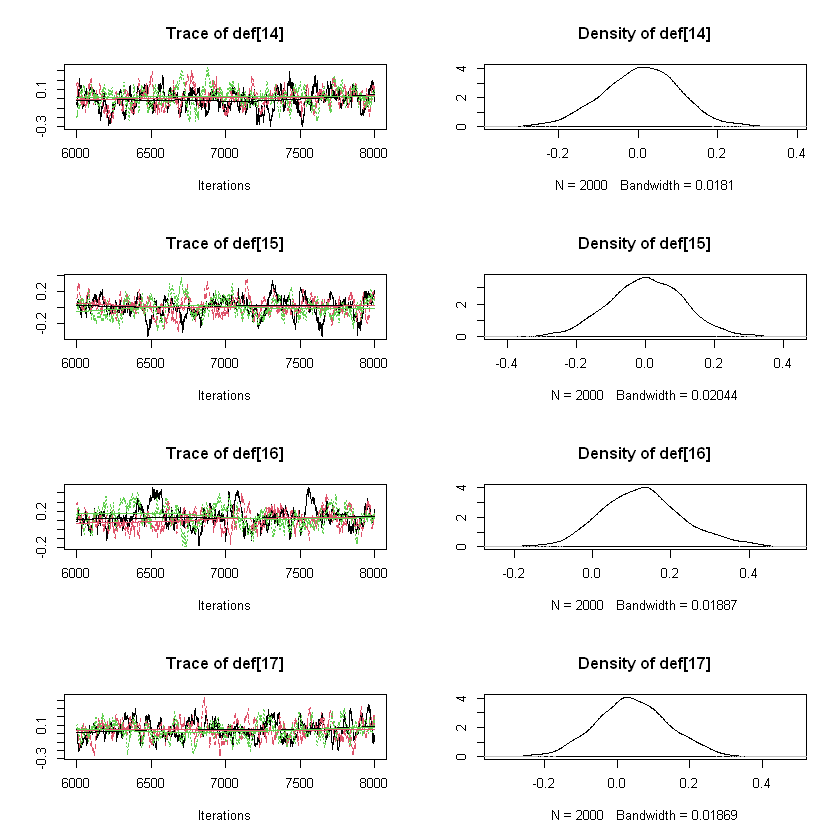

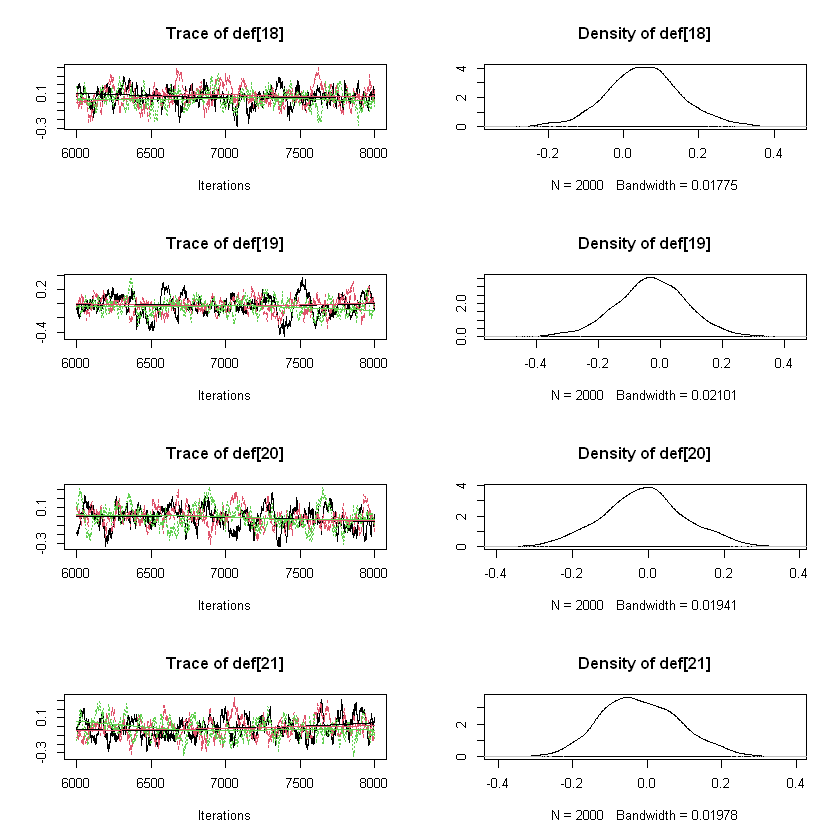

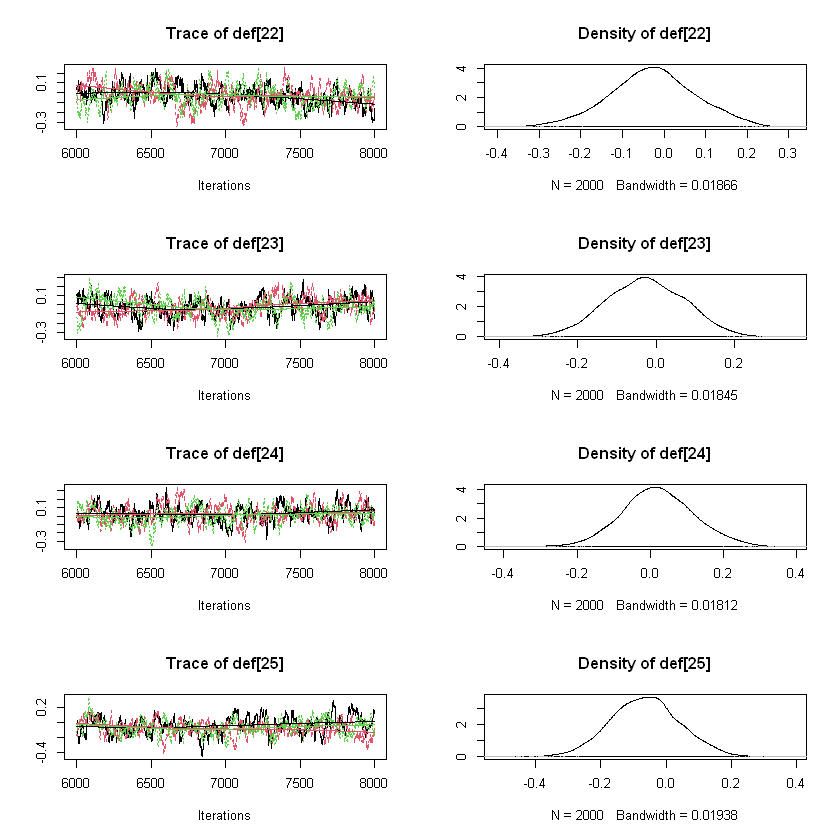

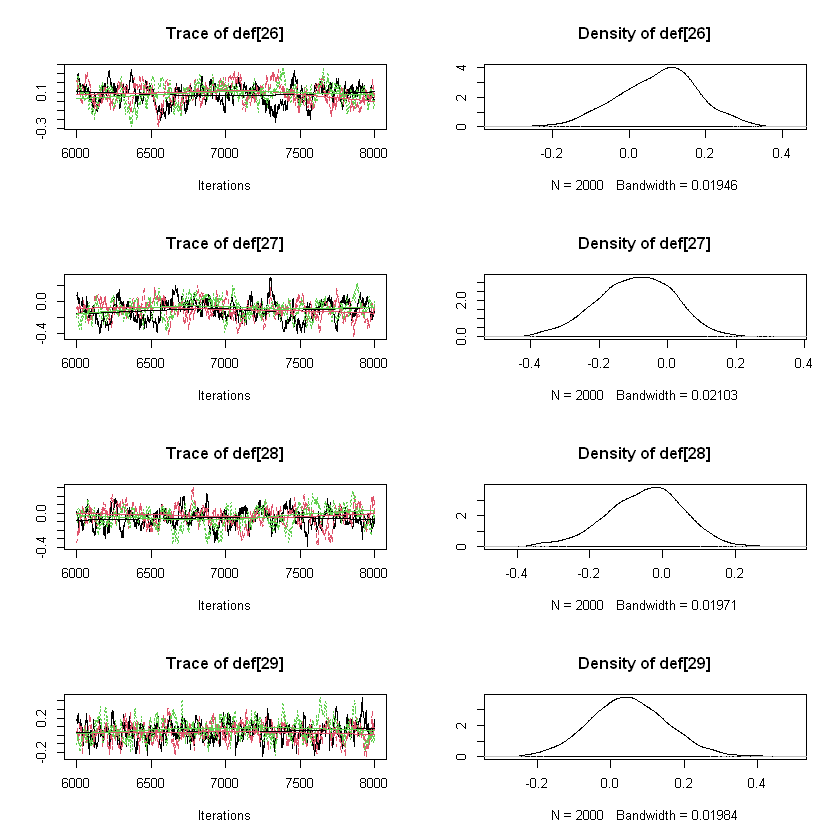

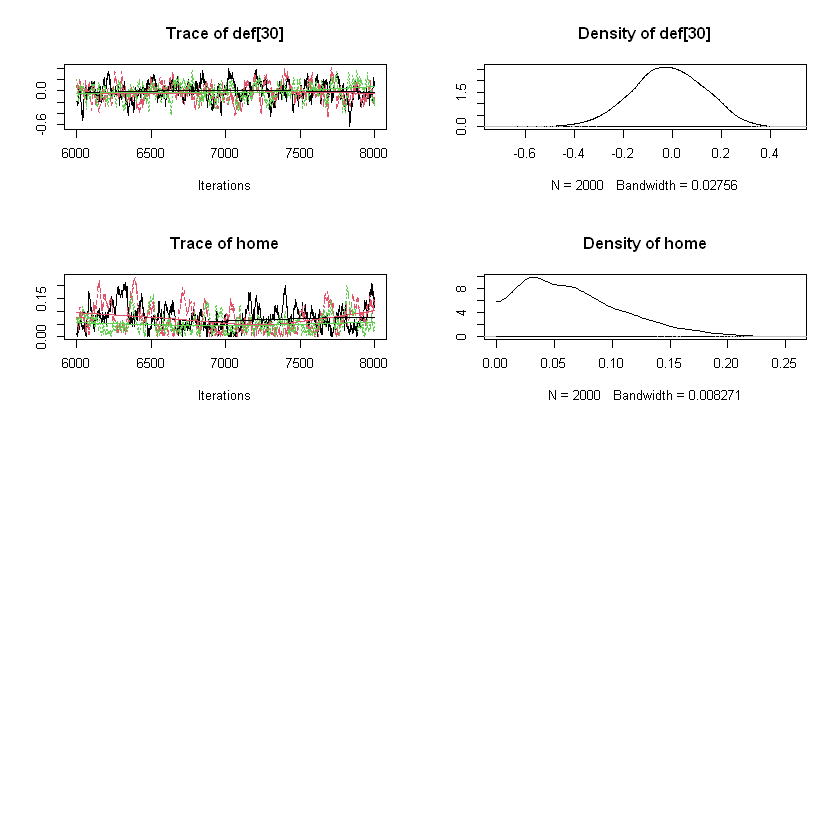

In [6]:
par(bg = 'white')
plot(samples_nb)

In [7]:
#jpeg('NB_FT_trace_density.jpeg')
#par(bg = 'white')
#plot(samples_nb)
#dev.off()

## Estimate RMSE

In [8]:
"   
    # Home
    HFT[i] ~ dpois(thetaH[i])
    log(thetaH[i]) <- att[H[i]] + def[A[i]] + c + home
    
    # Away
    AFT[i] ~ dpois(thetaA[i])
    log(thetaA[i]) <- att[A[i]] + def[H[i]] + c
"

[1] "   \n    # Home\n    HFT[i] ~ dpois(thetaH[i])\n    log(thetaH[i]) <- att[H[i]] + def[A[i]] + c + home\n    \n    # Away\n    AFT[i] ~ dpois(thetaA[i])\n    log(thetaA[i]) <- att[A[i]] + def[H[i]] + c\n"

In [9]:
N = nrow(df)
K = length(teams)

mean_vals_att <- summary(samples_nb)$statistics[1]
mean_vals_def <- summary(samples_nb)$statistics[32]

for (i in 2:K){
    mean_vals_att <- c(mean_vals_att, summary(samples_nb)$statistics[i])
}

for (j in 33:61){
    mean_vals_def <- c(mean_vals_def, summary(samples_nb)$statistics[j])
}

c_val <- summary(samples_nb)$statistics[31]
home_val <- summary(samples_nb)$statistics[62]

In [10]:
write.csv(mean_vals_att, 'NB_2p_att.csv')
write.csv(mean_vals_def, 'NB_2p_def.csv')
write.csv(c_val, 'NB_2p_c.csv')
write.csv(home_val, 'NB_2p_home.csv')

In [11]:
# estimate theta[i] ~ exp(att[H[i]] + def[A[i]] + c + home)
theta_1 = exp(mean_vals_att[1] + mean_vals_def[4] + c_val + home_val)
theta_1

[1] 19.54429